In [46]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [47]:
# 从分类的文件夹中创建dataset 数据
train_dir = r'2_class/train'
test_dir = r'2_class/test'

In [48]:
from torchvision import transforms
#transforms.Resize((256,256))
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

train_ds =  torchvision.datasets.ImageFolder(train_dir,transform=transform)
test_ds = torchvision.datasets.ImageFolder(test_dir,transform=transform)
train_ds.classes

['airplane', 'lake']

In [49]:
train_ds.class_to_idx

{'airplane': 0, 'lake': 1}

In [50]:
len(train_ds),len(test_ds)

(1120, 280)

In [51]:
BATCHSIZE=16

In [52]:
train_dl= torch.utils.data.DataLoader(train_ds,batch_size=BATCHSIZE,shuffle=True)

In [53]:
test_dl= torch.utils.data.DataLoader(test_ds,batch_size=BATCHSIZE)

In [54]:
imgs,labels = next(iter(train_dl))
imgs.shape

torch.Size([16, 3, 256, 256])

In [55]:
imgs[0].shape

torch.Size([3, 256, 256])

In [56]:
im = imgs[0].permute(1,2,0)
im.shape

torch.Size([256, 256, 3])

In [57]:
im = im.numpy()
type(im)

numpy.ndarray

In [58]:
im.shape

(256, 256, 3)

In [59]:
im.max(), im.min()

(1.0, -1.0)

In [60]:
im = (im+1)/2

In [61]:
im.max(),im.min()

(1.0, 0.0)

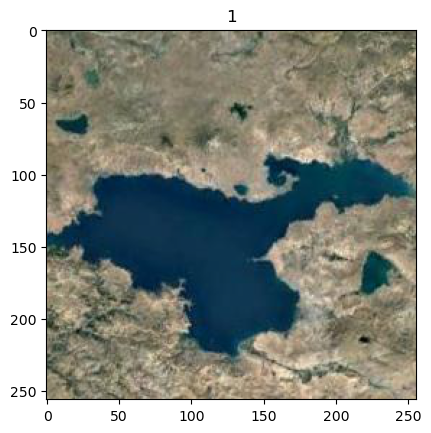

In [62]:
plt.title(labels[0].item())
plt.imshow(im)
plt.savefig('9_1_1.jpg',dpi=400)

In [63]:
labels[0].item()
train_ds.class_to_idx

{'airplane': 0, 'lake': 1}

In [64]:
id_to_class=dict((v,k) for k,v in train_ds.class_to_idx.items())

In [65]:
id_to_class

{0: 'airplane', 1: 'lake'}

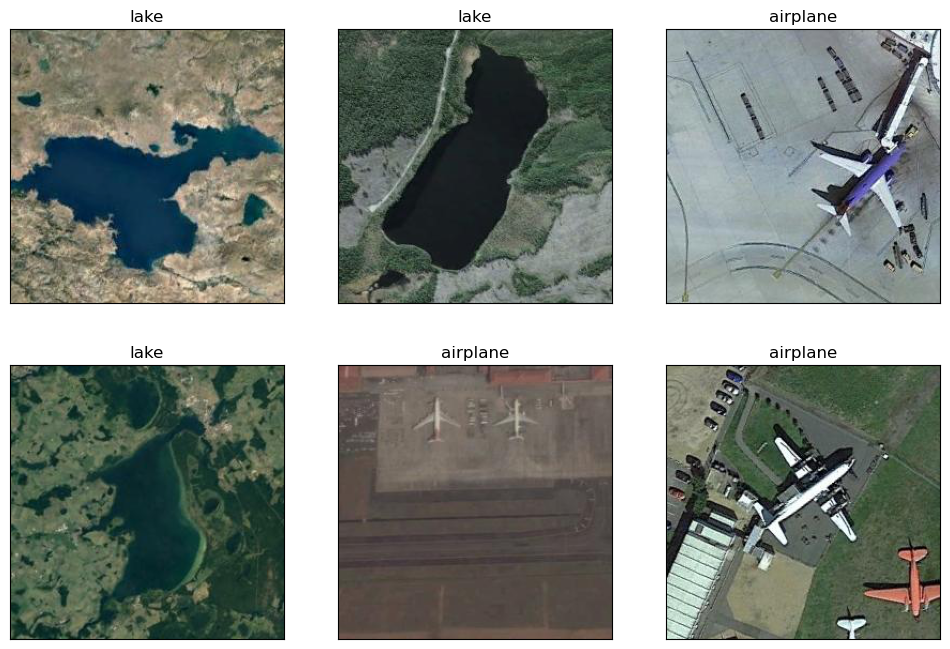

In [66]:
plt.figure(figsize=(12,8))
for i,(img,label) in enumerate(zip(imgs[:6],labels[:6])):
    img = (img.permute(1,2,0).numpy()+1)/2
    plt.subplot(2,3,i+1)
    plt.title(id_to_class.get(label.item()))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.savefig('4-2.jpg',dpi=400)

In [67]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64*30*30,1024)
        self.fc2 = nn.Linear(1024,2)
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(x,2)
        x=x.view(-1,64*30*30)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x


In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


Using cpu device


In [69]:
model= Net().to(device)
preds = model(imgs.to(device))

In [70]:
imgs.shape

torch.Size([16, 3, 256, 256])

In [71]:
preds.shape

torch.Size([16, 2])

In [72]:
torch.argmax(preds,1)

tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)


In [78]:
def train(dataloader,model,loss_fn,optimizer):
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss,correct =0,0
    model.train()
    for X,y in dataloader:
        X,y = X.to(device),y.to(device)

        #Compute prediction error
        pred = model(X)
        loss= loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
            train_loss+=loss.item()
    train_loss/=num_batches
    correct/=size
    return train_loss,correct

In [79]:
def test(dataloader,model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss,correct= 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /=num_batches
    correct/=size
    return test_loss,correct

In [80]:
epochs =30

In [81]:
train_loss =[]
train_acc=[]
test_loss=[]
test_acc=[]
for epoch in range(epochs):
    epoch_loss,epoch_acc =train(train_dl,model,loss_fn,optimizer)
    epoch_test_loss,epoch_test_acc = test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
print("Done!")

epoch: 0,train_loss:0.31895,train_acc:87.5%,test_loss:0.14622,test_acc:95.4%
epoch: 1,train_loss:0.14325,train_acc:95.4%,test_loss:0.31008,test_acc:90.4%
epoch: 2,train_loss:0.08993,train_acc:96.5%,test_loss:0.07842,test_acc:96.4%
epoch: 3,train_loss:0.04784,train_acc:98.5%,test_loss:0.05297,test_acc:98.6%
epoch: 4,train_loss:0.04096,train_acc:98.6%,test_loss:0.05942,test_acc:97.9%
epoch: 5,train_loss:0.01282,train_acc:99.6%,test_loss:0.09015,test_acc:97.5%
epoch: 6,train_loss:0.00363,train_acc:99.9%,test_loss:0.04616,test_acc:98.6%
epoch: 7,train_loss:0.01161,train_acc:99.7%,test_loss:0.13511,test_acc:97.1%
epoch: 8,train_loss:0.06289,train_acc:97.9%,test_loss:0.05117,test_acc:97.5%
epoch: 9,train_loss:0.02071,train_acc:99.2%,test_loss:0.05880,test_acc:98.6%
epoch:10,train_loss:0.00264,train_acc:100.0%,test_loss:0.02925,test_acc:98.2%
epoch:11,train_loss:0.00096,train_acc:100.0%,test_loss:0.02467,test_acc:98.6%
epoch:12,train_loss:0.00047,train_acc:100.0%,test_loss:0.03325,test_acc:98

#保存和加载模型权重

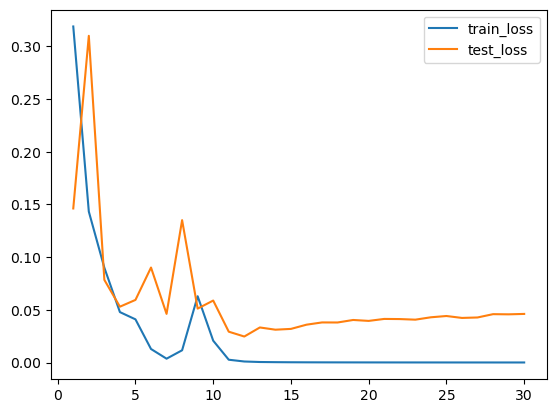

In [82]:
plt.plot(range(1,epochs+1),train_loss,label='train_loss')
plt.plot(range(1,epochs+1),test_loss,label='test_loss')
plt.legend()

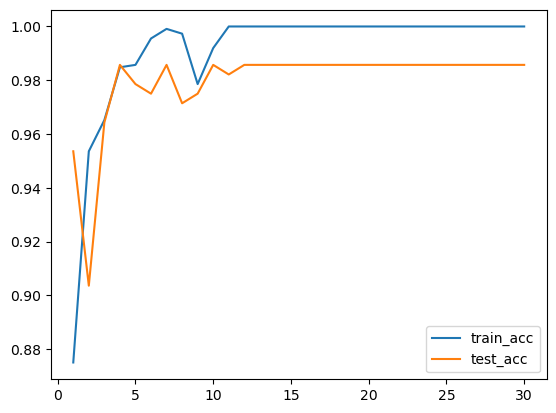

In [84]:
plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc')
plt.legend()

In [85]:
torch.save(model.state_dict(),'model_weights.pth')
new_model=Net()
new_model.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

In [86]:
new_model = new_model.to(device)
test(test_dl,new_model)

(0.046114233557678595, 0.9857142857142858)

保存整个模型

In [87]:
torch.save(model,'model.pth')
new_model2 = torch.load('model.pth')
new_model2.eval()
new_model2 = new_model2.to(device)
test(test_dl,new_model2)

(0.046114233557678595, 0.9857142857142858)

保存最优参数

In [88]:
import copy
best_model_wts = copy.deepcopy(model.state_dict())
best_acc =0.0
train_loss=[]
train_loss=[]
test_loss = []
test_acc = []
epochs = 3
for epoch in range(epochs):
    epoch_loss,epoch_acc = train(train_dl,model,loss_fn,optimizer)
    epoch_test_loss,epoch_test_acc = test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}% ,test_loss:{:.5f},test_acc:{:.1f}%")
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))

    if epoch_test_acc > best_acc:
        best_acc = epoch_test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
print("Done!")

model.load_state_dict(best_model_wts)
model.eval()

epoch: 0,train_loss:0.00002,train_acc:100.0% ,test_loss:0.04646,test_acc:98.6%
epoch: 1,train_loss:0.00002,train_acc:100.0% ,test_loss:0.04916,test_acc:98.6%
epoch: 2,train_loss:0.00002,train_acc:100.0% ,test_loss:0.04687,test_acc:98.6%
Done!


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

保存检查点
存和加载一般检查点模型进行推理或恢复培训可能有助于拾取上次离开的位置。在保存一般检查点时i，您必须保存的不仅仅是模型的state_dict.保存优化器的state_dict 也很重要，，因为这包含随着模型的训练的更新而更新的缓冲区和参数。
为了保存多个检查点，您必须将其组织在字典中，并用于将字典序列化，一个常见的pytorch惯例是使用文件扩展保存这些检查点，要加载项目，首先初始化模型和优化器，然后使用手电筒本地加载字典。

In [91]:
PATH = 'model_checkpoint.pt'
torch.save({'epoch':epochs,'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict()},PATH)

In [ ]:
#恢复检查点
#首先初始化模型和优化器，然后恢复检查点

In [93]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(),lr= 0.0005)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
PATH = "model_checkpoint_{}.pt"
for epoch in range(epochs):
    epoch_loss, epoch_acc = train(train_dl, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test(test_dl, model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

    template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ,"
                "test_loss: {:.5f}, test_acc: {:.1f}%")
    print(template.format(
          epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    #每个epoch训练结束执行保存检查点
    torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH.format(epoch))

print("Done!")